In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as transforms
plt.style.use('classic')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
annotations = pd.read_csv("data/faces.csv")
annotations.iloc[0]

image_name    00001722.jpg
width                 1333
height                2000
x0                     490
y0                     320
x1                     687
y1                     664
Name: 0, dtype: object

## Centerness

Centerness is is sort of a weighting in this case. We will get our final pred by multiplying the class_score with centerness

It is the sqrt(min(l,r)/max(l,r)*min(t,b)/max(t,b)), basically the ratio of the max and min distance horizontally and vertically from the sides. The bigger the number the closer the point is to the center. This helps with the 

In [183]:
def generate_centerness_map(bbxs, feature_map_size):
    centerness_map = np.zeros(feature_map_size)
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = bbox
        
        # Coord grid
        y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]), np.arange(feature_map_size[1]), indexing='ij')

        l = x_grid - xmin  # Dist to the left
        r = xmax - x_grid  # Dist to the right
        t = y_grid - ymin  # Dist to the top
        b = ymax - y_grid  # Dist to the bottom 

        # only pos nums
        l = np.clip(l, 0, None)
        r = np.clip(r, 0, None)
        t = np.clip(t, 0, None)
        b = np.clip(b, 0, None)

        # Calculate centerness score
        centerness = np.sqrt((np.minimum(l, r) / np.maximum(l, r)) * (np.minimum(t, b) / np.maximum(t, b)))
        
        # Replace NaNs with zeros
        centerness = np.nan_to_num(centerness)
        centerness_map = centerness_map + centerness
    
    return torch.tensor(centerness_map).view(1,128,128)

In [184]:
def generate_class_map(bbxs,feature_map_size):
    class_map = np.zeros((2,feature_map_size[0],feature_map_size[1]))
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        class_map[1][ymin:ymax,xmin:xmax]=1
    return torch.tensor(class_map).view(2,128,128)

In [185]:
def generate_bbox_map(bbxs,feature_map_size):
    img_size = np.array(feature_map_size)
    bbox_maps = np.full((4,img_size[0],img_size[1]),feature_map_size[0])
    y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]),np.arange(feature_map_size[1]), indexing='ij')

    for i,bbox in enumerate(bbxs):
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        l = x_grid - xmin
        r = xmax - x_grid
        t = y_grid - ymin
        b = ymax - y_grid
        if i < 1:
            bbox_maps[0][ymin:ymax,xmin:xmax] = l[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = r[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = t[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = b[ymin:ymax,xmin:xmax]
        else:
            l[l<0] = 2**31 - 1
            r[r<0] = 2**31 - 1
            t[t<0] = 2**31 - 1
            b[b<0] = 2**31 - 1
            bbox_maps[0][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[0],l)[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[1],r)[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[2],t)[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[3],b)[ymin:ymax,xmin:xmax]
    return torch.tensor(bbox_maps)

In [201]:
class FacesDataset(Dataset):
    
    def __init__(self,image_df,img_shape = (256,256)):
        super().__init__()
        self.img_dataframe = image_df
        self.img_tgt_shape = img_shape
        self.image_resize_transform = transforms.Resize(img_shape)

    def __len__(self):
        return self.img_dataframe.shape[0]
    
    def get_img(self,index):
        face_bbox = []
        path = 'data/images/' + annotations.iloc[index]['image_name']
        img = pil_to_tensor(Image.open(path))
        x_scale, y_scale = img.shape[2]/self.img_tgt_shape[1], img.shape[1]/self.img_tgt_shape[0] 
        img = self.image_resize_transform(img)
        query_df = annotations[(self.img_dataframe.image_name == self.img_dataframe.iloc[index]['image_name'] )].copy()
        for index,row in query_df.iterrows():
            face_bbox.append([row['x0']// x_scale, row['y0']// y_scale, row['x1']// x_scale, row['y1']// y_scale])
        return img,face_bbox
    
    def __getitem__(self, index):
        img,face_bbox = self.get_img(index)
        img = img.permute(1,2,0)
        centerness_map=generate_centerness_map(face_bbox,img.shape[:2])
        class_map=generate_class_map(face_bbox,img.shape[:2])
        bbox_maps=generate_bbox_map(face_bbox,img.shape[:2])
        label = torch.cat((centerness_map,class_map,bbox_maps),dim=0)
        img = img.permute(2,0,1)
        return img.float(),label
    
    def plot_img(self,idx):
        img, bboxes = self.get_img(idx)
        img = img.permute(1,2,0)
        plt.figure(figsize=(12,8))
        # Display the image
        plt.imshow(img)

        # Get the current reference
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Create a Rectangle patch
        for bbox in bboxes:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

        plt.show()

In [202]:
ds = FacesDataset(annotations,(128,128))

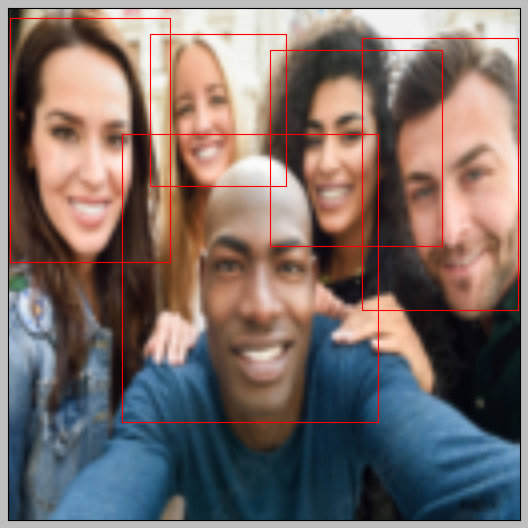

In [203]:
ds.plot_img(120)

In [204]:
class FCOS_NN(nn.Module):
    def __init__(self,num_of_fpn_layers,num_of_classes, num_of_starting_channels = 32, num_of_ending_channels = 128):
        super().__init__()
        self.conv1 = nn.Conv2d(3,num_of_starting_channels,kernel_size=3,padding=1)
        self.fpn = nn.ModuleList()
        self.refine_conv = nn.ModuleList()
        self.upscale = nn.ModuleList()
        input_channels = num_of_starting_channels
        output_channels = num_of_starting_channels*2
        factor = 2
        for _ in range(num_of_fpn_layers):
            self.fpn.append(nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            ))
            self.refine_conv.append(nn.Sequential(
                nn.Conv2d(output_channels,num_of_ending_channels,kernel_size=1,padding=0),
                nn.BatchNorm2d(num_of_ending_channels),
                nn.ReLU()
            ))
            self.upscale.append(
                nn.Upsample(scale_factor=factor,mode='bilinear')
            )
            factor = factor*2
            input_channels = output_channels
            output_channels = output_channels*2
        self.cls_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,num_of_classes,kernel_size=3,padding=1)
        )
        self.bbox_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,4,kernel_size=3,padding=1)
        )
        self.centerness_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,1,kernel_size=3,padding=1)
        )
        

    def forward(self,x):
        feature_layers = []
        x = self.conv1(x)
        for layer in self.fpn:
            x = layer(x)
            feature_layers.append(x)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.refine_conv)):
            feature_layers[i] = layer(feature)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.upscale)):
            feature_layers[i] = layer(feature)
        x = feature_layers[0]
        for i in range(len(feature_layers)-1):
            x = x + feature_layers[i+1]
        cls_pred = self.cls_head(x)
        bbox_pred = self.bbox_head(x)
        centerness_pred = self.centerness_head(x)
        return centerness_pred,cls_pred,bbox_pred

In [205]:
model = FCOS_NN(num_of_fpn_layers = 4,num_of_classes = 2,num_of_ending_channels=256)
X = torch.rand((1,3,128,128))
cls_pred,bbox_pred,centerness_pred = model(X)
cls_pred.shape,bbox_pred.shape,centerness_pred.shape

(torch.Size([1, 1, 128, 128]),
 torch.Size([1, 2, 128, 128]),
 torch.Size([1, 4, 128, 128]))

torch.Size([1, 128, 128]) torch.Size([2, 128, 128]) torch.Size([4, 128, 128])
torch.Size([128, 128, 1]) torch.Size([2, 128, 128]) torch.Size([4, 128, 128])


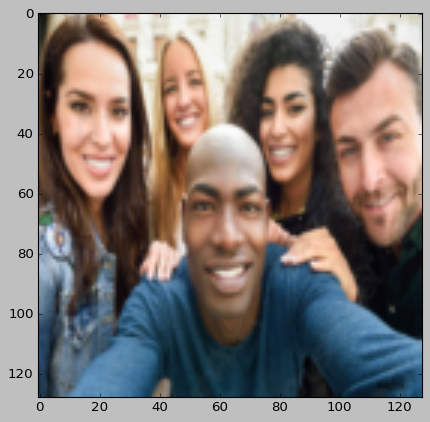

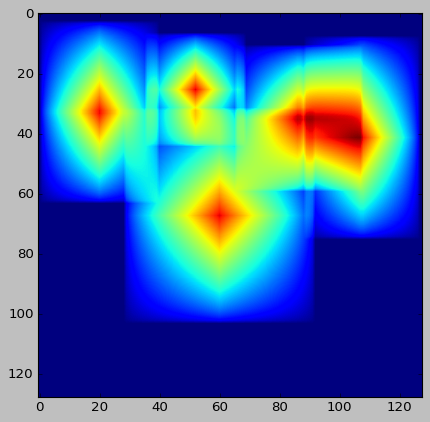

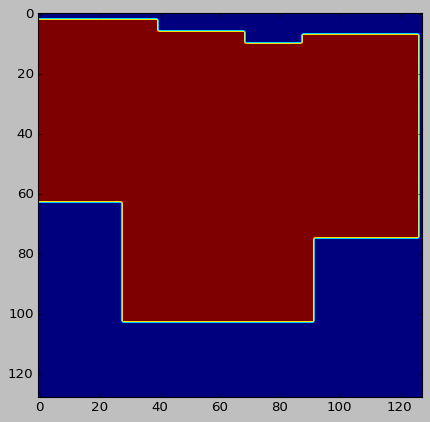

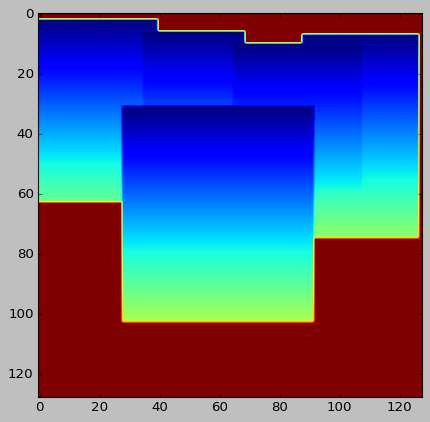

In [223]:
img,bbxs = ds.__getitem__(120)
img = img.permute(1,2,0).int()
centerness_map = bbxs[:1].permute(1,2,0)
class_map = bbxs[1:3]
bbox_maps = bbxs[3:]
print(centerness_map.shape,class_map.shape,bbox_maps.shape)
plt.imshow(img)
plt.show()
plt.imshow(centerness_map)
plt.show()
plt.imshow(class_map[1])
plt.show()
plt.imshow(bbox_maps[2])

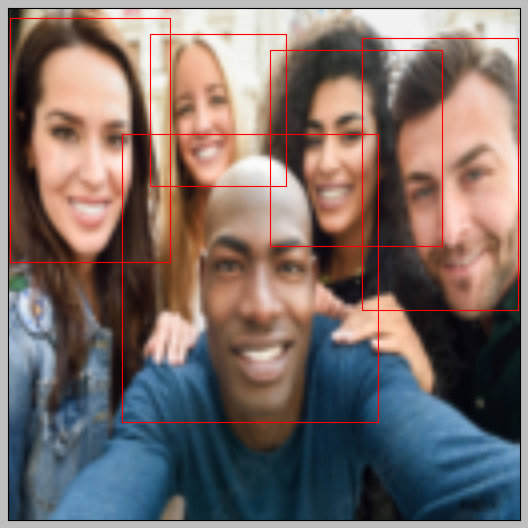

In [224]:
ds.plot_img(120)